# Approximation Interpretation

> In this notebook, I try to demonstrate an explanation for the approximation.

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
import gc
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Sequence, Tuple

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.svd_helpers import projection_matrix_for_rank_k_approximation
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer,
    FilenameForToken,
)
from transformer_experiments.experiments.cosine_sims import (
    filter_on_prefiltered_results,
)


## Preliminaries
Let's instantiate the model, grab the 20,000 strings we used to analyze the quality of the approximation, run them all through the model, and grab the feed-forward network outputs at each layer. 

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is local_mac


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
# Get all the unique substrings of length 10 from the text
strings10 = all_unique_substrings(text=ts.text, substring_length=10)

In [ ]:
n_prompts = 20000

torch.manual_seed(1337)
indices = torch.randperm(len(strings10))[:n_prompts]
prompts = [strings10[i.item()] for i in indices]
prompts[:5]

['is dreams,', 'by present', 's eyes may', 'eart of ho', ' man, as I']

In [ ]:
# Tokenize the strings
tokens = encoding_helpers.tokenize_strings(prompts)

# Embed the tokens
accessors = TransformerAccessors(m, device)
embeddings = accessors.embed_tokens(tokens)

# Run them through the model with hooks attached that let us look at
# intermediate values
_, io_accessors = accessors.run_model(embeddings)

In [ ]:
# Grab the outputs of the ffwd networks at each layer
ffwd_outs = torch.stack([
    io_accessors[block_idx].output('ffwd')[:, -1, :].clone()
    for block_idx in range(n_layer)
])

ffwd_outs.shape

torch.Size([6, 20000, 384])

In [ ]:
# Free up some memory
del io_accessors
_ = gc.collect()

Now let's set ourselves up to find similar strings based on the pre-filtered cosine similarities.

In [ ]:
prefiltered_threshold=0.7
prefiltered_results_folder = environment.data_root / 'cosine_sim_results/large_files/slen10' / f'prefiltered_{prefiltered_threshold}'

def prefiltered_filename(block_idx: int, q_idx: int) -> Path:
    return prefiltered_results_folder / f'cosine_sim_ffwd_out_{q_idx:05d}_{block_idx:02d}.pt'

def load_prefiltered_data(block_idx: int, q_idx: int):
    return torch.load(prefiltered_filename(block_idx, q_idx))

In [ ]:
similarity_thresholds=[0.95, 0.94, 0.85, 0.76, 0.81, 0.89]

Lastly, let's define some basic building blocks we'll need.

In [ ]:
next_token_map10 = build_next_token_map(
    text=ts.text,
    prefix_len=10,
    vocab_size=tokenizer.vocab_size,
    stoi=tokenizer.stoi
)

In [ ]:
def hellinger_distance(
    p: torch.Tensor,
    q: torch.Tensor,
):
    return ((p.sqrt() - q.sqrt())**2).sum(dim=-1).sqrt() / math.sqrt(2)

In [ ]:
def plot_prob_distribution_for_tokens(
    prob_distribution: torch.Tensor,
    title: str = "",
    ax: Optional[Axes] = None,
    figsize=(12, 4),
):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_indices = np.arange(tokenizer.vocab_size)
    x_labels = [repr(c)[1:-1] for c in tokenizer.chars]

    ax.bar(x_indices, prob_distribution)
    ax.set_xticks(x_indices, x_labels, rotation="vertical")
    ax.set_title(title)
    ax.set_ylim(0.0, 1.0)

    return ax

## Hypothesis


Let's think about the transformer model from the end and go backwards. At the end of the sequence of blocks, the model has computed some value in embedding space. It then sends this through a final layer norm and then a final linear layer, which produces a value in logit space. The softmax operation at the very end transforms the logits into probabilities, one for each token. 

My hypothesis of what's going on is:

* There's a subspace of the whole embedding space that corresponds to each token being predicted. 
* The value computed by the feed forward network provides an "adjustment" to the input embedding that orients it towards the subspaces that correspond to the next token probabilities defined by the similar strings. 

## Approximating Token Subspaces

In [ ]:
def create_token_subspace_projection_matrices(
    subspace_dims: int,
    load_token_embeddings: Callable[[str], torch.Tensor],
    all_tokens: Sequence[str],
) -> torch.Tensor:
    """Returns a tensor of projection matrices that project onto
    the `subspace_dims`-dimensional space that approximates the
    subspace for each token. Returned tensor is of shape
    (vocab_size, n_embed, n_embed)."""

    return torch.stack([
        projection_matrix_for_rank_k_approximation(
            original_matrix=load_token_embeddings(token),
            k=subspace_dims,
        )
        for token in all_tokens
    ])

In [ ]:
def topk_similar_projections(
    token_subspace_projection_matrices: torch.Tensor,
    embedding: torch.Tensor,
    k: int,
    all_tokens: Sequence[str],
) -> Sequence[Tuple[str, float]]:
    """Projects `embedding` onto the subspaces for each token and then
    calculates the cosine similarity between the projected vector and
    `embedding`. Determines the top `k` most similar, and returns a
    sequence of tuples of the form (token, cosine_similarity)."""

    assert token_subspace_projection_matrices.ndim == 3
    assert token_subspace_projection_matrices.shape[1] == token_subspace_projection_matrices.shape[2]
    assert token_subspace_projection_matrices.shape[1] == embedding.shape[0]

    projections = token_subspace_projection_matrices @ embedding

    values, indices = torch.topk(
        F.cosine_similarity(projections, embedding, dim=-1),
        k=k,
        dim=0,
    )
    tokens = [all_tokens[i.item()] for i in indices]
    return list(zip(tokens, values.tolist()))

## Demonstrating the Hypothesis

### Setup

In [ ]:
learned_embeddings_dir = environment.data_root / 'learned_embeddings'
assert learned_embeddings_dir.exists(), "Learned embeddings directory doesn't exist. Run the code in experiments/learn-embeddings.ipynb to learn embeddings."

In [ ]:
filename_for_token = FilenameForToken(tokenizer)

In [ ]:
def perform_approximation(block_idx: int, q_idx: int) -> torch.Tensor:
    # Find similar strings
    similar_indices = filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: load_prefiltered_data(block_idx, q_idx),
        q_idx_start=q_idx,
        q_idx_end=q_idx+1,
        filter_fn=lambda values: values > similarity_thresholds[block_idx]
    )
    similar_strings = [
        [strings10[i] for i in indices]
        for indices in similar_indices
    ]

    # Compute Probability Distribution from Similar Strings
    total_freq_distribution = torch.stack(
        [next_token_map10[string] for string in similar_strings[0]]
    ).sum(dim=0)
    prob_distribution = total_freq_distribution / total_freq_distribution.sum()

    return prob_distribution, len(similar_strings[0])

In [ ]:
def perform_approximation_and_plot(block_idx: int, q_idx: int):
    prob_distribution, n_strings = perform_approximation(block_idx, q_idx)

    print(f"Found {n_strings} similar strings.")

    # Plot the probability distribution
    plot_prob_distribution_for_tokens(
        prob_distribution,
        title=f"Probability Distribution from Approximation (block_idx={block_idx}, q_idx={q_idx}, prompt={repr(prompts[q_idx])})",
    )

### Examples for the Final Output Head: Output Embedding --> Logits (No Blocks)

In [ ]:
no_blocks_proj_matrices = create_token_subspace_projection_matrices(
    subspace_dims=1,
    load_token_embeddings=lambda token: torch.load(
        learned_embeddings_dir /  'no_blocks' / f"{filename_for_token(token)}.pt",
        map_location=device,
    )[:, 0, :],
    all_tokens=tokenizer.chars
)
no_blocks_proj_matrices.shape

torch.Size([65, 384, 384])

Found 3 similar strings.


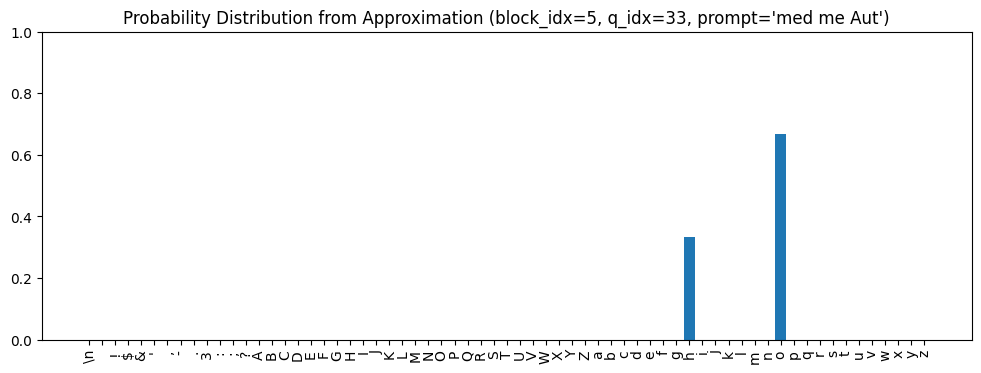

In [ ]:
block_idx = 5
q_idx = 33
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(no_blocks_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('o', 0.5074884295463562),
 ('h', 0.40787822008132935),
 ('i', 0.26926180720329285),
 ('u', 0.22823508083820343),
 ('y', 0.20325089991092682)]

Found 823 similar strings.


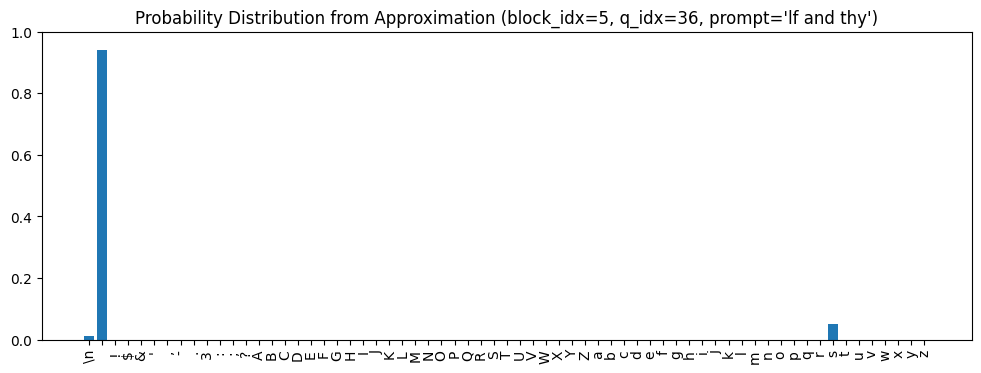

In [ ]:
block_idx = 5
q_idx = 36
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(no_blocks_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[(' ', 0.5869003534317017),
 ('s', 0.47689366340637207),
 ('\n', 0.38412901759147644),
 ('$', 0.23048195242881775),
 ('a', 0.21783535182476044)]

### Examples with One Block: Block 5 --> Logits

In [ ]:
block_5_proj_matrices = create_token_subspace_projection_matrices(
    subspace_dims=1,
    load_token_embeddings=lambda token: torch.load(
        learned_embeddings_dir /  'block_5' / f"{filename_for_token(token)}.pt",
        map_location=device,
    )[:, 0, :],
    all_tokens=tokenizer.chars
)
block_5_proj_matrices.shape

torch.Size([65, 384, 384])

Found 3 similar strings.


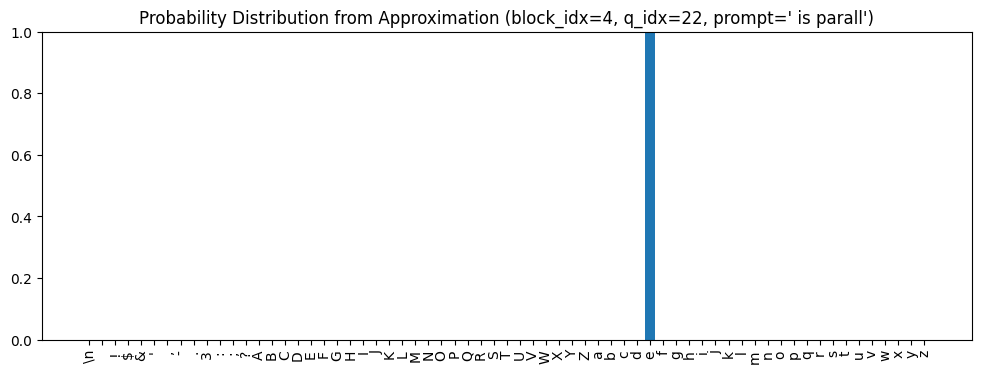

In [ ]:
block_idx = 4
q_idx = 22
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(block_5_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('e', 0.39072519540786743),
 ('t', 0.22815877199172974),
 ('w', 0.16565938293933868),
 ('O', 0.16220779716968536),
 ("'", 0.15983152389526367)]

Found 13 similar strings.


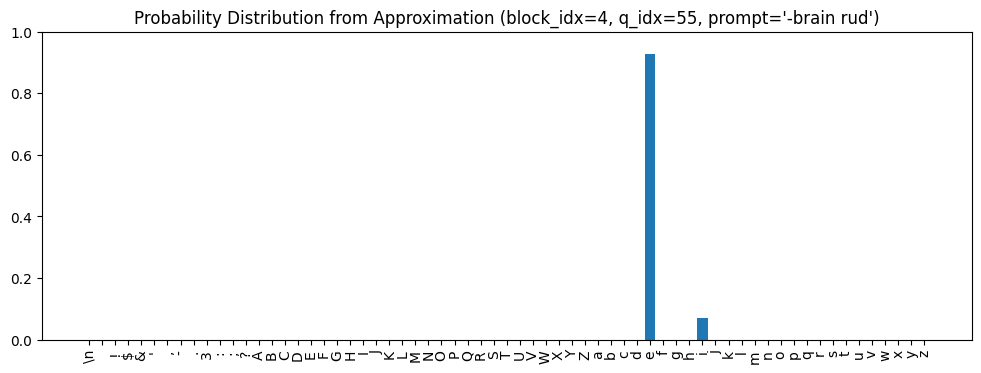

In [ ]:
block_idx = 4
q_idx = 55
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(block_5_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('e', 0.3601665794849396),
 ('l', 0.19291123747825623),
 ('O', 0.172983318567276),
 ('r', 0.15273427963256836),
 ('V', 0.14703969657421112)]

It doesn't work that well. 

What if we tried a higher dimensional approximation?

In [ ]:
topk_similar_projections(
    create_token_subspace_projection_matrices(
        subspace_dims=3,
        load_token_embeddings=lambda token: torch.load(
            learned_embeddings_dir /  'block_5' / f"{filename_for_token(token)}.pt",
            map_location=device,
        )[:, 0, :],
        all_tokens=tokenizer.chars
    ),
    ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars
)

[('e', 0.3763144314289093),
 ('l', 0.21268059313297272),
 ('Q', 0.19100935757160187),
 ('r', 0.1881854087114334),
 ('p', 0.18020297586917877)]

Not much changed. What if we try sampling more embeddings, like 1000, instead of 100?

In [ ]:
topk_similar_projections(
    create_token_subspace_projection_matrices(
        subspace_dims=3,
        load_token_embeddings=lambda token: torch.load(
            learned_embeddings_dir /  'block_5_1000' / f"{filename_for_token(token)}.pt",
            map_location=device,
        )[:, 0, :],
        all_tokens=tokenizer.chars
    ),
    ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars
)

[('e', 0.45469194650650024),
 ('l', 0.23989447951316833),
 ('r', 0.2296566665172577),
 ('Q', 0.22248920798301697),
 ('u', 0.18954990804195404)]

Not much changed. What if we try 5000?

In [ ]:
topk_similar_projections(
    create_token_subspace_projection_matrices(
        subspace_dims=3,
        load_token_embeddings=lambda token: torch.load(
            learned_embeddings_dir /  'block_5_5000' / f"{filename_for_token(token)}.pt",
            map_location=device,
        )[:, 0, :],
        all_tokens=tokenizer.chars
    ),
    ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars
)

[('e', 0.4560593366622925),
 ('l', 0.2688257694244385),
 ('r', 0.2324495017528534),
 ('Q', 0.2060614824295044),
 ('b', 0.20078855752944946)]

### Examples with Two Blocks: Block 4 --> Logits

In [ ]:
block_4_proj_matrices = create_token_subspace_projection_matrices(
    subspace_dims=1,
    load_token_embeddings=lambda token: torch.load(
        learned_embeddings_dir /  'block_4' / f"{filename_for_token(token)}.pt",
        map_location=device,
    )[:, 0, :],
    all_tokens=tokenizer.chars
)
block_4_proj_matrices.shape

torch.Size([65, 384, 384])

Found 90 similar strings.


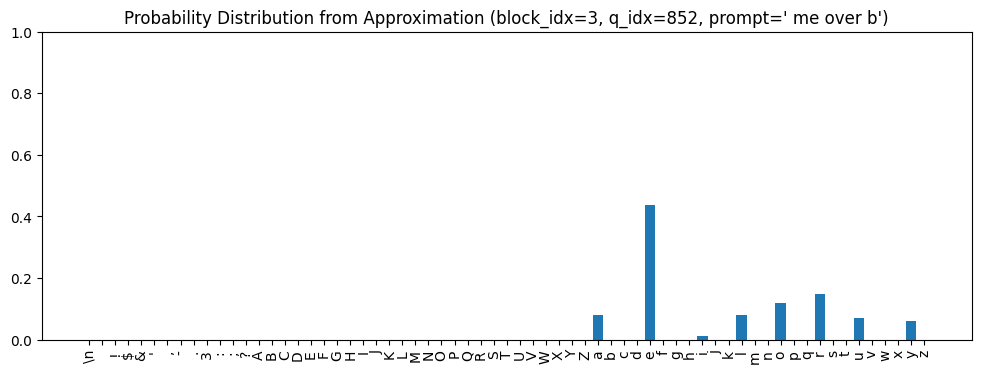

In [ ]:
block_idx = 3
q_idx = 852
perform_approximation_and_plot(block_idx, q_idx)

In [ ]:
topk_similar_projections(block_4_proj_matrices, ffwd_outs[block_idx, q_idx, :], k=5, all_tokens=tokenizer.chars)

[('n', 0.21810972690582275),
 ('R', 0.14459426701068878),
 ('c', 0.1221529021859169),
 ('G', 0.11818694323301315),
 ('U', 0.11376696825027466)]

## Aggregate Performance

### Output Embedding --> Logits (No Blocks)

In [ ]:
block_idx = 5
approx_tokens = []
approx_probs = []
subspace_tokens = []
prob_threshold = 0.99 # We'll include however many tokens needed to cover this much probability mass
for q_idx in tqdm(range(n_prompts)):
    distribution, _ = perform_approximation(block_idx, q_idx)

    # Find the number of tokens needed to cover `prob_threshold` probability mass
    sorted = distribution.sort(descending=True)
    n_tokens = distribution.shape[0] - (sorted.values.cumsum(dim=0) > prob_threshold).sum() + 1
    approx_tokens.append(
        [
            tokenizer.itos[i.item()]
            for i in sorted.indices[:n_tokens]
        ]
    )
    approx_probs.append(sorted.values[:n_tokens])

    tokens, _ = zip(
        *topk_similar_projections(
            no_blocks_proj_matrices,
            ffwd_outs[block_idx, q_idx, :],
            k=n_tokens,
            all_tokens=tokenizer.chars,
        )
    )
    subspace_tokens.append(tokens)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
prob_threshold = 0.90
top_n = 3
count = 0
for i in range(n_prompts):
    # Figure out how many tokens we need to look at to get to
    # `prob_threshold` cumulative probability.
    n_tokens = min(
        approx_probs[i].shape[0] - (approx_probs[i].cumsum(dim=0) > prob_threshold).sum() + 1,
        min(approx_probs[i].shape[0], top_n)
    )


    if all([approx_tokens[i][j] in subspace_tokens[i] for j in range(n_tokens)]):
        count += 1

print(f"{count:>5} ({count / n_prompts:.2%}) queries had 90% of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")


14877 (74.39%) queries had 90% of the predicted probability mass or top 3 tokens in the list of top token subspaces.


### Block 5 --> Logits (1 Block)

In [ ]:
block_idx = 4
approx_tokens = []
approx_probs = []
subspace_tokens = []
prob_threshold = 0.99 # We'll include however many tokens needed to cover this much probability mass
for q_idx in tqdm(range(n_prompts)):
    distribution, _ = perform_approximation(block_idx, q_idx)

    # Find the number of tokens needed to cover `prob_threshold` probability mass
    sorted = distribution.sort(descending=True)
    n_tokens = distribution.shape[0] - (sorted.values.cumsum(dim=0) > prob_threshold).sum() + 1
    approx_tokens.append(
        [
            tokenizer.itos[i.item()]
            for i in sorted.indices[:n_tokens]
        ]
    )
    approx_probs.append(sorted.values[:n_tokens])

    tokens, _ = zip(
        *topk_similar_projections(
            no_blocks_proj_matrices,
            ffwd_outs[block_idx, q_idx, :],
            k=n_tokens,
            all_tokens=tokenizer.chars,
        )
    )
    subspace_tokens.append(tokens)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
prob_threshold = 0.90
top_n = 3
count = 0
for i in range(n_prompts):
    # Figure out how many tokens we need to look at to get to
    # `prob_threshold` cumulative probability.
    n_tokens = min(
        approx_probs[i].shape[0] - (approx_probs[i].cumsum(dim=0) > prob_threshold).sum() + 1,
        min(approx_probs[i].shape[0], top_n)
    )


    if all([approx_tokens[i][j] in subspace_tokens[i] for j in range(n_tokens)]):
        count += 1

print(f"{count:>5} ({count / n_prompts:.2%}) queries had 90% of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")

11045 (55.23%) queries had 90% of the predicted probability mass or top 3 tokens in the list of top token subspaces.


### Block 4 --> Logits (2 Block)

In [ ]:
block_idx = 3
approx_tokens = []
approx_probs = []
subspace_tokens = []
prob_threshold = 0.99 # We'll include however many tokens needed to cover this much probability mass
for q_idx in tqdm(range(n_prompts)):
    distribution, _ = perform_approximation(block_idx, q_idx)

    # Find the number of tokens needed to cover `prob_threshold` probability mass
    sorted = distribution.sort(descending=True)
    n_tokens = distribution.shape[0] - (sorted.values.cumsum(dim=0) > prob_threshold).sum() + 1
    approx_tokens.append(
        [
            tokenizer.itos[i.item()]
            for i in sorted.indices[:n_tokens]
        ]
    )
    approx_probs.append(sorted.values[:n_tokens])

    tokens, _ = zip(
        *topk_similar_projections(
            no_blocks_proj_matrices,
            ffwd_outs[block_idx, q_idx, :],
            k=n_tokens,
            all_tokens=tokenizer.chars,
        )
    )
    subspace_tokens.append(tokens)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
prob_threshold = 0.90
top_n = 3
count = 0
for i in range(n_prompts):
    # Figure out how many tokens we need to look at to get to
    # `prob_threshold` cumulative probability.
    n_tokens = min(
        approx_probs[i].shape[0] - (approx_probs[i].cumsum(dim=0) > prob_threshold).sum() + 1,
        min(approx_probs[i].shape[0], top_n)
    )


    if all([approx_tokens[i][j] in subspace_tokens[i] for j in range(n_tokens)]):
        count += 1

print(f"{count:>5} ({count / n_prompts:.2%}) queries had 90% of the predicted probability mass or top {top_n} tokens in the list of top token subspaces.")


 8051 (40.26%) queries had 90% of the predicted probability mass or top 3 tokens in the list of top token subspaces.
